# Wake Field Contours for a 3×3 Wind Farm


In [8]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt

# Detect notebook working directory
notebook_cwd = os.getcwd()

# Project root = one level up from notebooks/
project_root = os.path.abspath(os.path.join(notebook_cwd, ".."))

# Add project root to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

# Now import using package syntax
from src.turbine import Turbine
from src.farm import WindFarm
from src.wake_model import velocity_deficit, is_in_wake, wake_radius


In [9]:
# Load turbine specs
data_path = os.path.join("..", "data", "turbine_specs.json")
with open(data_path, "r") as f:
    specs = json.load(f)

D = specs["rotor_diameter"]
C_T = specs["thrust_coefficient"]
P_rated = specs["rated_power_kw"]

# Spacing: 5D in x and y
spacing = 5 * D

turbines = []
for i in range(3):      # x direction (0, 1, 2)
    for j in range(3):  # y direction (0, 1, 2)
        x = i * spacing
        y = j * spacing
        turbines.append(Turbine(x, y, D, C_T, P_rated))

len(turbines), [(t.x, t.y) for t in turbines]


(9,
 [(0, 0),
  (0, 600),
  (0, 1200),
  (600, 0),
  (600, 600),
  (600, 1200),
  (1200, 0),
  (1200, 600),
  (1200, 1200)])

In [10]:
U_inf = 8.0   # m/s
k = 0.04      # wake expansion coefficient

def effective_speed_at_point(x, y, turbines, U_inf, k):
    """
    Compute effective wind speed at a point (x, y)
    due to wakes from all upstream turbines.
    Wind from left to right.
    """
    deficits = []

    for t in turbines:
        # Only upstream turbines
        if t.x >= x:
            continue

        if is_in_wake(x, y, t.x, t.y, t.R, k):
            dx = x - t.x
            dU = velocity_deficit(dx, U_inf, t.C_T, t.R, k) * U_inf
            deficits.append(dU)

    if not deficits:
        return U_inf

    total_deficit = np.sqrt(np.sum(np.array(deficits) ** 2))
    return max(U_inf - total_deficit, 0.0)


In [11]:
# Grid resolution: 200 x 200 (option B)
nx, ny = 200, 200

# Define grid bounds slightly beyond turbines
x_min = -0.5 * D
x_max = 10 * D + 0.5 * D
y_min = -0.5 * D
y_max = 10 * D + 0.5 * D

xs = np.linspace(x_min, x_max, nx)
ys = np.linspace(y_min, y_max, ny)

U_field = np.zeros((ny, nx))

for i, y in enumerate(ys):
    for j, x in enumerate(xs):
        U_field[i, j] = effective_speed_at_point(x, y, turbines, U_inf, k)

U_field.min(), U_field.max()


(np.float64(2.8530676041947176), np.float64(8.0))

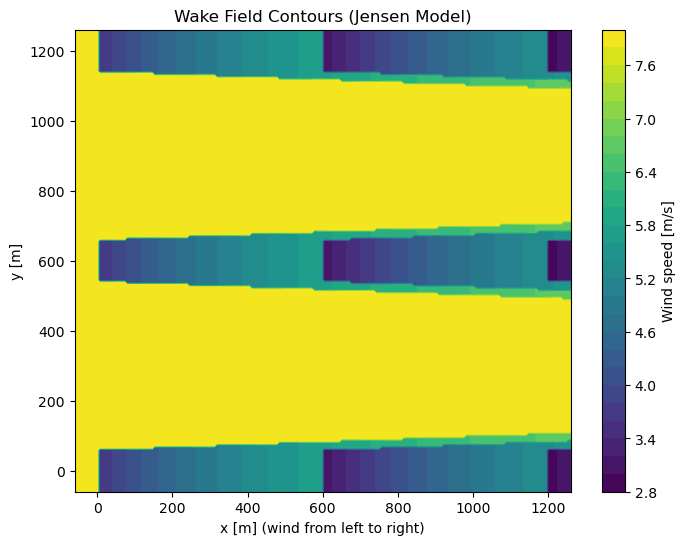

In [12]:
results_dir = os.path.join("..", "results")
os.makedirs(results_dir, exist_ok=True)

X, Y = np.meshgrid(xs, ys)

plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, U_field, levels=30, cmap="viridis")
cbar = plt.colorbar(contour)
cbar.set_label("Wind speed [m/s]")

plt.xlabel("x [m] (wind from left to right)")
plt.ylabel("y [m]")
plt.title("Wake Field Contours (Jensen Model)")

contour_path = os.path.join(results_dir, "wake_contour.png")
plt.savefig(contour_path, dpi=300, bbox_inches="tight")
plt.show()


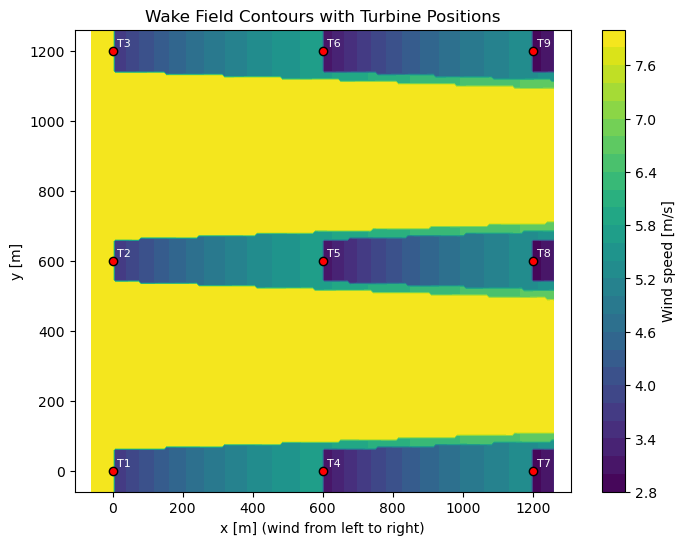

In [13]:
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, U_field, levels=30, cmap="viridis")
cbar = plt.colorbar(contour)
cbar.set_label("Wind speed [m/s]")

# Plot turbines
tx = [t.x for t in turbines]
ty = [t.y for t in turbines]
plt.scatter(tx, ty, c="red", edgecolors="black", zorder=3)
for i, t in enumerate(turbines):
    plt.text(t.x + 0.1 * D, t.y + 0.1 * D, f"T{i+1}", color="white", fontsize=8)

plt.xlabel("x [m] (wind from left to right)")
plt.ylabel("y [m]")
plt.title("Wake Field Contours with Turbine Positions")
plt.axis("equal")

contour_turbines_path = os.path.join(results_dir, "wake_contour_with_turbines.png")
plt.savefig(contour_turbines_path, dpi=300, bbox_inches="tight")
plt.show()
